In [ ]:
import numpy as np 
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

# Recomendación. Campaña de email marketing.

# Objetivo

- Desarrollar una estrategia de email marketing dirigida a 10,000 clientes, priorizando los productos que generen mayor beneficio.



# Aspectos a tener en cuenta

1. Modelos de Predicción:

- Crear modelos predictivos para determinar qué productos tienen mayor probabilidad de ser contratados por cada cliente.
- Considerar no solo la probabilidad de contratación, sino también el beneficio económico de cada producto.
- Utilizar técnicas de modelado avanzadas como árboles de decisión, regresión logística y redes neuronales.
- Validar y evaluar los modelos utilizando métricas como la precisión, el recall y el AUC-ROC.
2. Selección de Clientes:
- Seleccionar los 10,000 clientes que recibirán los emails basados en los resultados del modelo predictivo.
- Justificar la elección de estos clientes y la estrategia empleada.

# Enfoques para la creación de los modelos predictivos

1. Creación de un modelo para cada producto:

- En este enfoque, se crearía un modelo predictivo separado para cada producto (por ejemplo, uno para short_term_deposit, otro para loans, otro para mortgage, etc.).

- Ventajas: Es específico para cada producto. El modelo se entrenaría específicamente para un producto, lo que permite que aprenda patrones únicos relacionados con la contratación de ese producto.
- Interpretabilidad: Los factores que influyen en la contratación de cada producto pueden ser más fáciles de interpretar.
- Desventajas: Sería costoso en términos de recursos ya que requiere entrenar y mantener múltiples modelos. Además, muchos de los modelos podrían utilizar características similares, lo que significa que se estaría trabajando doble.

2. Modelo agrupado por tipos de productos:

- Se agruparían los productos similares en categorías, exactamente como lo explicaba Erin (Responsable de Marketing Directo) en uno de sus correos [cuentas, productos de ahorro e inversión (planes, fondos, etc.) y financiación (préstamos y tarjetas)].

- Ventajas: Menos modelos que mantener en comparación con la opción de un modelo por producto. Además, se pueden identificar patrones que se aplican a categorías de productos.
- Desventajas: Puede que no capture detalles específicos de un solo producto tan bien como un modelo dedicado.

3. Modelo General para Todos los Productos:

- Se utilizaría un único modelo para predecir la probabilidad de que un cliente contrate cualquier producto.
- Ventajas: Es simple, solo hay que entrenar y mantener un único modelo, por tanto menos recursos computacionales y menos tiempo de entrenamiento.
- Desventajas: Puede ser más complejo interpretar las relaciones ya que el modelo tiene que captar información de todos los productos y si un producto es raro comparado con otros, el modelo puede no predecirlo correctamente.



# Procedimiento para la creación de los modelos predictivos.

Teniendo en cuenta lo anterior, a continuación se muestra el procedimiento a deasrrollar para resolver esta Tarea:

- Se trabajará a partir de un Modelo General Inicial que prediga la probabilidad de contratación de productos en general.


1. Preparación de Datos

- Se carga el dataset df_full_cleaned desde S3 de AWS
  
- Se crea la variable objetivo (compra): una columna binaria que indica si el cliente ha comprado algún producto (1) o no (0), independientemente del producto que sea, es decir, si al menos a comprado un producto es (1) si no es (0) .
- Se hace la partición de los datos en conjunto de entrenamiento y prueba.

2. Iteración 1: Modelos Iniciales. Para el entrenamiento se van a tener en cuenta los siguientes modelos:

- Regresión Logística
- Random Forest
- XGBoost
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)

- Se usará accuracy, precision, recall, F1-score para evaluar el rendimiento de cada modelo en el conjunto de prueba y se analiza el comportamiento de los modelos, así como la importancia de las características. 

3. Iteración 2: Feature Engineering

- Se crean nuevas características, generando interacciones o combinaciones de variables, teneindo en cuenta las caracteristicas más relevantes en la Iteración 1.

- Entrenar y evaluar los mismos modelos que en la iteración 1, con las nuevas características.

4. Iteración 3: Refinamiento del Modelo

- Análisis de las características menos relevantes según su importancia en los modelos anteriores.

- Se vuelven a entrenar los modelos, se evaluan y se comparan los resultados.

5. Selección del modelo y ajuste de hiperparámetros

- A partir del modelo que mejor comportamiento presente se realiza un ajuste de hiperparámetros usando GridSearchCV. 
 
- Se evalua el rendimiento final del modelo ajustado en el conjunto de prueba.

NOTA: A la hora de ajustar los hiperparámetros, lo normal sería realizar el análisis para cada uno de los modelos, ya que existe la posibilidad de que un modelo pueda mejorar con respecto a otro pero en este caso se toma la decisión, para ahorrar recursos, de realizar el ajuste para un solo modelo, el de mejor comportameinto en la Iteración 3.



---

## 1. Preparación de datos.

In [3]:
# cargando el dataset completo directamente desde S3 de AWS

df_full = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
df_full


,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


In [5]:
# Creación de la variable objetivo

df_full["compra"] = df_full["num_products_contracts"].apply(lambda x: 1 if x > 0 else 0)

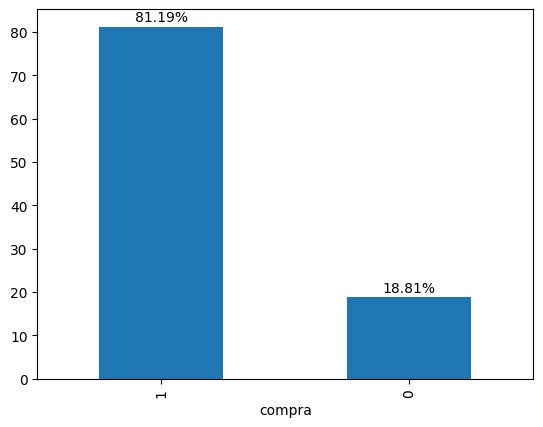

In [32]:
# Comportamiento de la variable objetivo

(df_full["compra"].value_counts(normalize=True)*100).plot(kind="bar")
for i, v in enumerate(df_full["compra"].value_counts(normalize=True)*100):
    plt.text(i, v + 0.5, str(round(v, 2)) + "%", ha='center', va='bottom')